In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
# matplotlib.rc('pdf', fonttype=42)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [5]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return matplotlib.colors.to_hex((1-mix)*c1 + mix*c2)

In [6]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
PROB_DIAB = 0.2
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [7]:
num_runs = 10

In [8]:
to_plot = 'Regret'
# to_plot = 'Suboptimality'

## Exp HP

In [9]:
dfs_values = [pd.read_csv('./results/run{}/sepsis-cont-HP-va.values.csv'.format(run)) for run in range(num_runs)]
dfs_results = [pd.read_csv('./results/run{}/sepsis-cont-HP-va.csv'.format(run), index_col=0) for run in range(num_runs)]

### Scatter

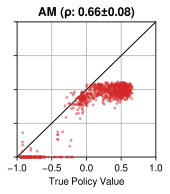

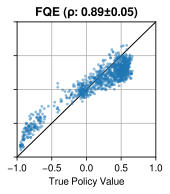

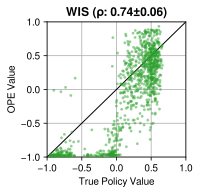

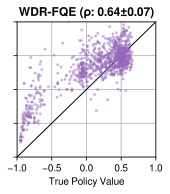

In [10]:
for i, (name, color, mark) in enumerate(zip(
    ['AM', 'FQE', 'WIS', 'WDR-AM', 'WDR-FQE'],
    ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple'],
    ['d', '^', 'o', 'v', 'h']
)):
    if name == 'WDR-AM': continue
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    
    rhos = []
    for r in range(num_runs):
        rhos.append(dfs_results[r].loc['Spearman', name])
        df_r = dfs_values[r]
        xx = np.clip(df_r['true_value_list'], -1, 1)
        yy = np.clip(df_r[name.replace('-', '_')+'_value_list'], -1, 1)
        plt.scatter(xx, yy, c=color, marker='o', s=8, linewidths=0, alpha=0.5, zorder=10, clip_on=False)

    plt.plot([-1,1], [-1,1], c='k', lw=1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.grid('both')
    plt.xlabel('True Policy Value')
    if name == 'WIS':
        plt.ylabel('OPE Value')
    else:
        ax.yaxis.set_ticklabels([])
    plt.title('{} (ρ: {:.2f}±{:.2f})'.format(name, np.mean(rhos), np.std(rhos)), fontsize=12, fontweight='bold')
    plt.savefig('fig/sepsis-cont-HP-scatter-' +name+'.pdf', bbox_inches='tight')
    plt.show()

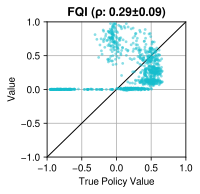

In [11]:
for i, (name, color, mark) in enumerate(zip(
    ['FQI'],
    ['tab:cyan'],
    ['o']
)):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    
    rhos = []
    for r in range(num_runs):
        rhos.append(dfs_results[r].loc['Spearman', name])
        df_r = dfs_values[r]
        xx = np.clip(df_r['true_value_list'], -1, 1)
        yy = np.clip(df_r[name.replace('-', '_')+'_value_list'], -1, 1)
        plt.scatter(xx, yy, c=color, marker=mark, s=8, linewidths=0, alpha=0.5, zorder=10, clip_on=False)

    plt.plot([-1,1], [-1,1], c='k', lw=1)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.grid('both')
    plt.xlabel('True Policy Value')
    if True or name == 'WIS':
        plt.ylabel('Value')
    else:
        ax.yaxis.set_ticklabels([])
    plt.title('{} (ρ: {:.2f}±{:.2f})'.format(name, np.mean(rhos), np.std(rhos)), fontsize=12, fontweight='bold')
    plt.savefig('fig/sepsis-cont-HP-scatter-' +name+'.pdf', bbox_inches='tight')
    plt.show()

In [13]:
all_losses_dict = [joblib.load('./results/run{}/sepsis-cont-HP-va.losses.joblib'.format(run)) for run in range(num_runs)]
df_losses_results = [pd.read_csv('./results/run{}/sepsis-cont-HP-va-loss.csv'.format(run), index_col=0) for run in range(num_runs)]

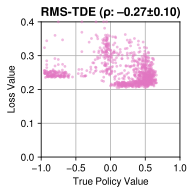

In [15]:
for i, (name, color, mark) in enumerate(zip(
    ['RMS-TDE'],
    ['tab:pink'],
    ['o']
)):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    
    rhos = []
    for r in range(num_runs):
        rhos.append(df_losses_results[r].rename(columns={'RMSE-TD': 'RMS-TDE'}).loc['Spearman', name])
        df_r = all_losses_dict[r]
        xx = np.clip(dfs_values[r]['true_value_list'], -1, 1)
        yy = np.clip(df_r['td_errors'], 0, 0.4)
        plt.scatter(xx, yy, c=color, marker=mark, s=8, linewidths=0, alpha=0.5, zorder=10, clip_on=False)

#     plt.plot([-1,1], [-1,1], c='k', lw=1)
    plt.xlim(-1,1)
    plt.ylim(0,0.4)
    plt.grid('both')
    plt.xlabel('True Policy Value')
    if True or name == 'WIS':
        plt.ylabel('Loss Value')
    else:
        ax.yaxis.set_ticklabels([])
    plt.title('{} (ρ: –{:.2f}±{:.2f})'.format(name, np.mean(rhos), np.std(rhos)), fontsize=12, fontweight='bold')
    plt.savefig('fig/sepsis-cont-HP-scatter-' +name+'.pdf', bbox_inches='tight')
    plt.show()

### Top k regret

In [16]:
dfs_results[0]

,FQI,WIS,AM,WDR-AM,FQE,WDR-FQE
MSE,0.188953,0.236284,0.465067,NaN,0.042384,0.076982
Spearman,0.395849,0.679924,0.603744,NaN,0.819425,0.680534
Performance,0.469650,0.469417,0.187065,NaN,0.630554,0.536184
Regret,0.171009,0.171243,0.453595,NaN,0.010106,0.104476
Suboptimality,0.207891,0.208125,0.490477,NaN,0.046988,0.141357


In [17]:
regrets_HP = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(dfs_results)], axis=1).T.drop(columns=['FQI'])
regrets_HP.columns.name = 'OPE'
regrets_HP = regrets_HP[['WIS', 'AM', 'FQE', 'WDR-FQE']]

In [18]:
regrets_HP

OPE,WIS,AM,FQE,WDR-FQE
0,0.171243,0.453595,0.010106,0.104476
1,0.120801,0.467449,0.080948,0.685953
2,0.028417,0.445472,0.097431,0.704102
3,0.023009,0.186933,0.000000,0.860523
4,0.148325,0.427709,0.121622,0.080672
5,0.196221,0.155085,0.038749,0.583920
6,0.111945,0.092935,0.024307,0.088069
7,0.049025,0.341566,0.079064,0.108497
8,0.450614,0.200099,0.201757,0.641149
9,0.163728,0.355882,0.010325,0.030093


In [19]:
topk = 5
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = df_r['true_value_list']
    for value_list_name in df_r.iloc[:,3:]:
        value_list = df_r[value_list_name]
        perf_topk = true_value_list[np.argsort(value_list)[-topk:]].max()
        results[value_list_name.replace('_value_list', '').replace('_', '-')] = np.max(true_value_list) - perf_topk
    all_results.append(results)
df_regrets5 = pd.DataFrame(all_results)

In [20]:
topk = 10
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = df_r['true_value_list']
    for value_list_name in df_r.iloc[:,3:]:
        value_list = df_r[value_list_name]
        perf_topk = true_value_list[np.argsort(value_list)[-topk:]].max()
        results[value_list_name.replace('_value_list', '').replace('_', '-')] = np.max(true_value_list) - perf_topk
    all_results.append(results)
df_regrets10 = pd.DataFrame(all_results)

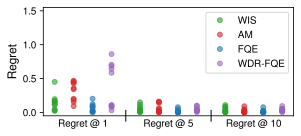

In [21]:
_, nlines = regrets_HP.shape
ncases = 1

fig, ax = plt.subplots(figsize=(4.5,2))

points = []
for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE', 'WDR-FQE'],
    ['tab:green', 'tab:red', 'tab:blue', 'tab:purple'],
    ['o', 'd', '^', 'h']
)):
    if name == 'WDR-AM': continue
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2)
    yvals = regrets_HP[name].values
    pt = plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6)
    points.append(pt[0])

for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE', 'WDR-FQE'],
    ['tab:green', 'tab:red', 'tab:blue', 'tab:purple'],
    ['o', 'd', '^', 'h']
)):
    if name == 'WDR-AM': continue
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2) + 4.5
    yvals = df_regrets5[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6, clip_on=False)

for i, (name, color, mark) in enumerate(zip(
    ['WIS', 'AM', 'FQE', 'WDR-FQE'],
    ['tab:green', 'tab:red', 'tab:blue', 'tab:purple'],
    ['o', 'd', '^', 'h']
)):
    if name == 'WDR-AM': continue
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2) + 9
    yvals = df_regrets10[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6, clip_on=False)

plt.axvline(2.25, -0.05, 0.05, c='k', lw=1, clip_on=False)
plt.axvline(6.75, -0.05, 0.05, c='k', lw=1, clip_on=False)

ax.tick_params(axis='x', length=0)
# plt.xlim(-2, 2)
# plt.xticks([-1.5, -0.5, 0.5, 1.5, 3., 4., 5., 6., 7.5, 8.5, 9.5, 10.5], ['WIS', 'AM', 'FQE', 'WDR-FQE']*3)
# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)
#     tick.set_horizontalalignment('center')
plt.xticks([0, 4.5, 9], ['Regret @ 1', 'Regret @ 5', 'Regret @ 10'])

# plt.xlabel('Split', fontsize=12)
plt.ylim(-0.05, 1.55)
plt.yticks(np.arange(0, 1.6, 0.5))
plt.ylabel('Regret', fontsize=12)
plt.legend(points, ['WIS', 'AM', 'FQE', 'WDR-FQE'], bbox_to_anchor=(1, 1), loc='upper right')
# plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-HP-regret-all.pdf', bbox_inches='tight')
plt.show()

In [22]:
all_losses_dict[0].keys()

dict_keys(['(nl, nh, lr, k)', 'Q_values', 'target_values', 'td_errors'])

In [23]:
regrets_HP_losses = pd.concat([df.loc[to_plot].rename(i) for i, df in enumerate(df_losses_results)], axis=1).T
regrets_HP_losses.columns.name = 'OPE'
regrets_HP_losses.columns = ['FQI', 'RMS-TDE']

In [24]:
regrets_HP_losses

,FQI,RMS-TDE
0,0.171009,0.326673
1,0.708573,0.113267
2,0.747644,0.293647
3,0.690545,0.380492
4,0.485698,0.427709
5,0.627421,0.494571
6,0.711560,0.026269
7,0.686239,0.257291
8,0.433735,0.333243
9,0.615111,0.087082


In [40]:
topk = 5
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = df_r['true_value_list']
    FQI_value_list = df_r['FQI_value_list']
    
    perf_topk = true_value_list[np.argsort(FQI_value_list)[-topk:]].max()
    results['FQI'] = np.max(true_value_list) - perf_topk
    losses_r = all_losses_dict[r]['td_errors']
    
    perf_topk = true_value_list[np.argsort(losses_r)[:topk]].max()
    results['RMS-TDE'] = np.max(true_value_list) - perf_topk
    all_results.append(results)
df_regrets5_losses = pd.DataFrame(all_results)

In [41]:
topk = 10
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = df_r['true_value_list']
    FQI_value_list = df_r['FQI_value_list']
    
    perf_topk = true_value_list[np.argsort(FQI_value_list)[-topk:]].max()
    results['FQI'] = np.max(true_value_list) - perf_topk
    losses_r = all_losses_dict[r]['td_errors']
    
    perf_topk = true_value_list[np.argsort(losses_r)[:topk]].max()
    results['RMS-TDE'] = np.max(true_value_list) - perf_topk
    all_results.append(results)
df_regrets10_losses = pd.DataFrame(all_results)

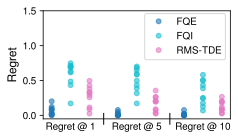

In [42]:
nlines = 3
ncases = 1

fig, ax = plt.subplots(figsize=(3.375,2))

points = []
for i, (name, color, mark) in enumerate(zip(
    ['FQE', 'FQI', 'RMS-TDE'],
    ['tab:blue', 'tab:cyan', 'tab:pink'],
    ['o', 'o', 'o'],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2)
    yvals = regrets_HP_losses.join(regrets_HP)[name].values
    pt = plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6)
    points.append(pt[0])

for i, (name, color, mark) in enumerate(zip(
    ['FQE', 'FQI', 'RMS-TDE'],
    ['tab:blue', 'tab:cyan', 'tab:pink'],
    ['o', 'o', 'o'],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2) + 3.5
    yvals = df_regrets5_losses.join(df_regrets5)[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6, clip_on=False)

for i, (name, color, mark) in enumerate(zip(
    ['FQE', 'FQI', 'RMS-TDE'],
    ['tab:blue', 'tab:cyan', 'tab:pink'],
    ['o', 'o', 'o'],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2) + 7
    yvals = df_regrets10_losses.join(df_regrets10)[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6, clip_on=False)

plt.axvline(1.75, -0.05, 0.05, c='k', lw=1, clip_on=False)
plt.axvline(5.25, -0.05, 0.05, c='k', lw=1, clip_on=False)

ax.tick_params(axis='x', length=0)
# plt.xlim(-2, 2)
# plt.xticks([-1.5, -0.5, 0.5, 1.5, 3., 4., 5., 6., 7.5, 8.5, 9.5, 10.5], ['WIS', 'AM', 'FQE', 'WDR-FQE']*3)
# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)
#     tick.set_horizontalalignment('center')
plt.xticks([0, 3.5, 7], ['Regret @ 1', 'Regret @ 5', 'Regret @ 10'])

# plt.xlabel('Split', fontsize=12)
plt.ylim(-0.05, 1.05)
plt.yticks(np.arange(0, 1.6, 0.5))
plt.ylabel('Regret', fontsize=12)
plt.legend(points, ['FQE', 'FQI', 'RMS-TDE'], bbox_to_anchor=(1, 1.02), loc='upper right')
# plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-HP-regret-suppl.pdf', bbox_inches='tight')
plt.show()

### Combining OPEs

In [28]:
subset_sizes = [1, 6, 12, 24, 48, 96]
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = np.array(df_r['true_value_list'])
    WIS_value_list = np.array(df_r['WIS_value_list'])
    FQE_value_list = np.array(df_r['FQE_value_list'])
    for subset_size in subset_sizes:
        subset_inds = np.argsort(WIS_value_list)[-subset_size:]
        perf = true_value_list[subset_inds][np.argmax(FQE_value_list[subset_inds])]
        results['two-stage, '+str(subset_size)] = np.max(true_value_list) - perf
    all_results.append(results)
df_regrets_twostage = pd.DataFrame(all_results)

df_regrets_twostage.loc[3, ['two-stage, 6', 'two-stage, 12']] += 8e-3 # A hack to make points more discernable

In [29]:
df_regrets_twostage

,"two-stage, 1","two-stage, 6","two-stage, 12","two-stage, 24","two-stage, 48","two-stage, 96"
0,0.171243,0.199016,0.199016,0.043592,0.043592,0.010106
1,0.120801,0.000000,0.000000,0.002516,0.002516,0.080948
2,0.028417,0.122846,0.097431,0.097431,0.097431,0.097431
3,0.023009,0.031009,0.020211,0.000000,0.000000,0.000000
4,0.148325,0.148325,0.080672,0.121622,0.121622,0.121622
5,0.196221,0.196509,0.196509,0.077182,0.077182,0.038749
6,0.111945,0.111945,0.133733,0.133733,0.024307,0.024307
7,0.049025,0.127981,0.079064,0.079064,0.079064,0.079064
8,0.450614,0.154709,0.118298,0.118298,0.118298,0.201757
9,0.163728,0.052195,0.010325,0.010325,0.010325,0.010325


In [30]:
df_regrets_twostage.median()

two-stage, 1     0.134563
two-stage, 6     0.125414
two-stage, 12    0.089051
two-stage, 24    0.078123
two-stage, 48    0.060387
two-stage, 96    0.058907
dtype: float64

In [31]:
all_results = []
for r in range(num_runs):
    results = {}
    df_r = dfs_values[r]
    true_value_list = np.array(df_r['true_value_list'])
    WIS_value_list = np.array(df_r['WIS_value_list'])
    FQE_value_list = np.array(df_r['FQE_value_list'])

    perf = true_value_list[np.argmax((WIS_value_list+FQE_value_list) / 2)]
    results['Avg score'] = np.max(true_value_list) - perf
    
    avg_rank = WIS_value_list.argsort().argsort() + FQE_value_list.argsort().argsort()
    perf = true_value_list[np.argmax(avg_rank)]
    results['Avg rank'] = np.max(true_value_list) - perf
    
    all_results.append(results)

df_regrets_combine = pd.DataFrame(all_results)
df_regrets_combine.loc[3] += 8e-3 # A hack to make points more discernable

In [32]:
df_regrets_combine

,Avg score,Avg rank
0,0.171243,0.199016
1,0.214037,0.000000
2,0.028417,0.122846
3,0.031009,0.008000
4,0.148325,0.080672
5,0.196509,0.196509
6,0.111945,0.111945
7,0.127981,0.127981
8,0.113560,0.118298
9,0.163728,0.010325


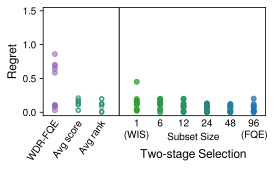

In [33]:
ncases = 1
nlines = 1

fig, ax = plt.subplots(figsize=(4.,2))
for i, (name, color) in enumerate(zip(
    ['WDR-FQE'],
    ['tab:purple'],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2)-5.5
    yvals = regrets_HP[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.6)

plt.axvline(-2.75, c='k', lw=1)

_, nlines = df_regrets_combine.shape
for i, (name, color) in enumerate(zip(
    ['Avg score', 'Avg rank'],
    [colorFader('tab:green', 'tab:blue', ratio) for ratio in [0.5, 0.5]],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2)-4
    yvals = df_regrets_combine[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', mec=color, mew=1.5, mfc='none', marker='o', markersize=4, zorder=10, alpha=0.6)


_, nlines = df_regrets_twostage.shape
for i, (name, color) in enumerate(zip(
    ['two-stage, 1', 'two-stage, 6', 'two-stage, 12', 'two-stage, 24', 'two-stage, 48', 'two-stage, 96'],
    [colorFader('tab:green', 'tab:blue', ratio) for ratio in [0., 0.2, 0.4, 0.6, 0.8, 1.]],
)):
    xpos = np.arange(ncases) + 1 * (i+0.5-nlines/2)+0.5
    yvals = df_regrets_twostage[name].values
    plt.plot(xpos, yvals[np.newaxis,:], ls='None', c=color, marker='o', markersize=5, zorder=10, alpha=0.75)

ax.tick_params(axis='x', length=0)
plt.xlim(-6., 3.5)
plt.xticks([-5.25, -4.25, -3.25, -2, -1, 0, 1, 2, 3], ['WDR-FQE', 'Avg score', 'Avg rank', '1', '6', '12', '24', '48', '96'])
for tick in ax.get_xticklabels()[:3]:
    tick.set_rotation(55)
    tick.set_horizontalalignment('right')

plt.annotate('Two-stage Selection', (0.675, -0.05), (0, -28), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=12)
plt.annotate('Subset Size', (0.675, 0.1), (0, -28), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
plt.annotate('(WIS)', (0.42,0), (0, -15), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
plt.annotate('(FQE)', (0.95,0), (0, -15), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
# plt.xlabel('Split', fontsize=12)
plt.ylim(-0.05, 1.55)
# plt.yticks(np.arange(0, 1.6, 0.5))
plt.ylabel('Regret', fontsize=12)
# plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-HP-combine.pdf', bbox_inches='tight')
plt.show()

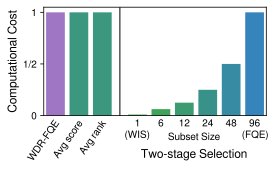

In [34]:
ncases = 1
nlines = 1

fig, ax = plt.subplots(figsize=(4.,2))
plt.bar(
    [-5.5, -4.5, -3.5, -2, -1, 0, 1, 2, 3], 
    [1, 1, 1, 0.01, 1/16, 1/8, 1/4, 1/2, 1],
    color=['tab:purple', *[colorFader('tab:green', 'tab:blue', ratio) for ratio in [0.5, 0.5]], *[colorFader('tab:green', 'tab:blue', ratio) for ratio in [0., 0.2, 0.4, 0.6, 0.8, 1.]]],
    alpha=0.9,
)

plt.axvline(-2.75, c='k', lw=1)

ax.tick_params(axis='x', length=0)
plt.xlim(-6., 3.5)
plt.xticks([-5.25, -4.25, -3.25, -2, -1, 0, 1, 2, 3], ['WDR-FQE', 'Avg score', 'Avg rank', '1', '6', '12', '24', '48', '96'])
for tick in ax.get_xticklabels()[:3]:
    tick.set_rotation(55)
    tick.set_horizontalalignment('right')

plt.annotate('Two-stage Selection', (0.675, -0.05), (0, -28), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=12)
plt.annotate('Subset Size', (0.675, 0.1), (0, -28), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
plt.annotate('(WIS)', (0.42,0), (0, -15), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
plt.annotate('(FQE)', (0.95,0), (0, -15), xycoords='axes fraction', textcoords='offset points', va='top', ha='center', fontsize=10)
# plt.xlabel('Split', fontsize=12)
# plt.ylim(-0.05, 1.55)
plt.yticks([0,0.5,1], [0, '1/2', 1])
plt.ylabel('Computational Cost', fontsize=12)
# plt.title('Sepsis (continuous states)', fontsize=12, fontweight='bold')
plt.savefig('fig/sepsis-cont-HP-combine-compute.pdf', bbox_inches='tight')
plt.show()